### Important Keyword

- Graph: the flow of the connection of nodes. In other words, it's the agent workflow.
- State: The current snapshot of the application. It's a shared memory for passing data.
- Nodes: tasks or action in form of function
- Edges: connections defining flow (specifying the node/function call)
- Executor: runs the graph and coordinates everything.

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random

In [3]:
load_dotenv(override=True)

True

### Building a Graph Without Using LLM

In [12]:
# source of AI response
nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [13]:
# define a state object
class State(BaseModel):
    messages: Annotated[list, add_messages]

In [14]:
# start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [15]:
# create a node
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)

    return new_state

# connect the node to the graph
graph_builder.add_node("first_node", our_first_node)

In [16]:
# the edges
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

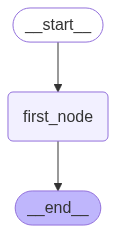

{'messages': [HumanMessage(content='alright', additional_kwargs={}, response_metadata={}, id='6e237070-6d71-4a6f-92df-2c477b7774fa'), AIMessage(content='Pickles are pedantic', additional_kwargs={}, response_metadata={}, id='3bf0c2dc-077b-4895-993e-d74fddbb3f2a')]}
{'messages': [HumanMessage(content='gogh', additional_kwargs={}, response_metadata={}, id='a1899bda-0a03-43ed-a6bc-ce481866dbdd'), AIMessage(content='Zombies are squishy', additional_kwargs={}, response_metadata={}, id='641733aa-47e2-412c-a466-6eba33bb3105')]}


In [17]:
# combine the graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Create a chat gradio application for the graph:

In [10]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content  # AI response displayed in gradio chat

In [11]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi there ', additional_kwargs={}, response_metadata={}, id='95bf8e80-0ce4-4601-bcae-d7e142931a4d'), AIMessage(content='Rainbows are moody', additional_kwargs={}, response_metadata={}, id='e101a4b6-3429-4fa9-9556-5006ba712576')]}
{'messages': [HumanMessage(content='Alright. I get you', additional_kwargs={}, response_metadata={}, id='973bcda5-3989-40e1-be30-0405e1e41a1a'), AIMessage(content='Toasters are squishy', additional_kwargs={}, response_metadata={}, id='6f06823c-a7d7-4684-a93e-af8b59822f73')]}


It is important to note that this is a simple example that used random words from list of words as the AI response. We can use an LLM instead.

In [18]:
class State(BaseModel):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot_node(old_state: State) -> State:
    response = llm.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()


In [19]:
def chat(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state) # super step: run the graph from start to end using user input to invoke it
    print(result)
    return result['messages'][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi ', additional_kwargs={}, response_metadata={}, id='3c812d14-86b6-4723-90b4-c272f4f2d1ad'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C4nDaRXQBlkGiG99hVuUVoZucLNi2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--acdba6b6-8c82-4fc6-a79c-362ee18b9e33-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
